In [14]:
%cd AI

/content/drive/MyDrive/Colab Notebooks


In [15]:
!ls

'1.1. Example: Polynomial Curve Fitting.ipynb'
'A demo of the mean-shift clustering algorithm.ipynb'
'Beta-divergence loss functions.ipynb'
'Comparison of LDA and PCA 2D projection of Iris dataset.ipynb'
'Decision Tree Regression.ipynb'
'Differential is Matrix.ipynb'
'K-means Clustering.ipynb'
'korean toknizer.ipynb'
'Multi-output Decision Tree Regression.ipynb'
'Non-linear SVM.ipynb'
'Outlier detection with Local Outlier Factor.ipynb'
'SVM: Separating hyperplane for unbalanced classes.ipynb'
'Transformer havardnlp.ipynb'
'Transformer Implementation.ipynb'


In [17]:
!git init

Initialized empty Git repository in /content/drive/MyDrive/Colab Notebooks/.git/


In [20]:
!git add .

In [21]:
!git status

On branch master

No commits yet

Changes to be committed:
  (use "git rm --cached <file>..." to unstage)

	new file:   1.1. Example: Polynomial Curve Fitting.ipynb
	new file:   A demo of the mean-shift clustering algorithm.ipynb
	new file:   Beta-divergence loss functions.ipynb
	new file:   Comparison of LDA and PCA 2D projection of Iris dataset.ipynb
	new file:   Decision Tree Regression.ipynb
	new file:   Differential is Matrix.ipynb
	new file:   K-means Clustering.ipynb
	new file:   Multi-output Decision Tree Regression.ipynb
	new file:   Non-linear SVM.ipynb
	new file:   Outlier detection with Local Outlier Factor.ipynb
	new file:   SVM: Separating hyperplane for unbalanced classes.ipynb
	new file:   Transformer Implementation.ipynb
	new file:   Transformer havardnlp.ipynb
	new file:   korean toknizer.ipynb



In [22]:
!rm -rf .git

In [ ]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import math, copy, time
from typing import NoReturn, Optional, Callable, Generator, Iterable
import matplotlib.pyplot as plt
import seaborn
from collections import OrderedDict

seaborn.set_context(context='talk')
%matplotlib inline

EncoderDecoder

In [ ]:
class EncoderDecoder(nn.Module):

  def __init__(self,
               encoder: nn.Module,
               decoder: nn.Module,
               src_embed: nn.Module,
               tgt_embed: nn.Module,
               generator: nn.Module) -> NoReturn:
    super(EncoderDecoder, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.tgt_embed = tgt_embed
    self.generator = generator

  def forward(self,
              src: torch.Tensor,
              tgt: torch.Tensor,
              src_mask: torch.Tensor,
              tgt_mask: torch.Tensor) -> torch.Tensor:
    return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

  def encode(self,
             src: torch.Tensor,
             src_mask: torch.Tensor) -> torch.Tensor:
    return self.encoder(self.src_embed(src), src_mask)

  def decode(self,
             memory: torch.Tensor,
             src_mask: torch.Tensor,
             tgt: torch.Tensor,
             tgt_mask: torch.Tensor):
    return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

Generator

In [ ]:
class Generator(nn.Module):
  def __init__(self, d_model: int, vocab: int) -> NoReturn:
    super(Generator, self).__init__()
    self.proj = nn.Linear(d_model, vocab)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return F.log_softmax(self.proj(x), dim=-1)

Encoder

In [ ]:
class Encoder(nn.Module):

  def __init__(self, encoder_layer: nn.Module, n_layer: int) -> NoReturn:
    super(Encoder, self).__init__()
    self.layers = clones(encoder_layer, n_layer)
    self.norm_layer = nn.LayerNorm(encoder_layer.size)

  def forward(self, x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    for layer in self.layers:
      x = layer(x, mask)
    x = self.norm_layer(x) # because of preLN
    return x

In [ ]:
class EncoderLayer(nn.Module):

  def __init__(self,
               size: int,
               multi_head_attention_layer: nn.Module,
               position_wise_feed_forward_layer: nn.Module,
               dropout: float) -> NoReturn:
    super(EncoderLayer, self).__init__()
    self.multi_head_attention_layer = multi_head_attention_layer
    self.attention_residual_connection_layer = ResidualConnectionLayer(size,
                                                                       dropout)
    #self.attention_residual_connection_layer = SublayerConnection(size, dropout)
    self.position_wise_feed_forward_layer = position_wise_feed_forward_layer
    self.ff_residual_connection_layer = ResidualConnectionLayer(size,
                                                                dropout)
    #self.ff_residual_connection_layer = SublayerConnection(size, dropout)
    self.size = size
  
  def forward(self,
              x: torch.Tensor,
              mask: torch.Tensor) -> torch.Tensor:
    out = self.attention_residual_connection_layer(
        x, lambda x: self.multi_head_attention_layer(x, x, x, mask)
    )
    out = self.ff_residual_connection_layer(
        out, self.position_wise_feed_forward_layer
    )
    return out

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
  def __init__(self, d_model: int, h: int) -> NoReturn:
    super(MultiHeadAttentionLayer, self).__init__()
    assert d_model % h == 0

    self.d_model = d_model
    self.d_k = d_model // h
    self.h = h
    self.query_fc_layer = nn.Linear(d_model, d_model)
    self.key_fc_layer = nn.Linear(d_model, d_model)
    self.value_fc_layer = nn.Linear(d_model, d_model)
    self.final_fc_layer = nn.Linear(d_model, d_model)

    self.attention_prob = None

  def calculate_attention(self,
                          query: torch.Tensor,
                          key: torch.Tensor,
                          value: torch.Tensor,
                          mask: torch.Tensor):
    d_k = key.size(-1)
    attention_score = torch.matmul(query, key.transpose(-2, -1))
    attention_score = attention_score / math.sqrt(d_k)
    if mask is not None:
      attention_score = attention_score.masked_fill(mask == 0, -1e9)
    attention_prob = F.softmax(attention_score, dim=-1)
    out = torch.matmul(attention_prob, value)
    return out, attention_prob

  def forward(self,
              query: torch.Tensor,
              key: torch.Tensor,
              value: torch.Tensor,
              mask: Optional[torch.Tensor]=None) -> torch.Tensor:
    n_batch = query.shape[0]

    def transform(x: torch.Tensor, fc_layer: nn.Module) -> torch.Tensor:
      out = fc_layer(x)
      out = out.view(n_batch, -1, self.h, self.d_k)
      out = out.transpose(1, 2)
      return out

    query = transform(query, self.query_fc_layer)
    key = transform(key, self.key_fc_layer)
    value = transform(value, self.value_fc_layer)

    if mask is not None:
      mask = mask.unsqueeze(1)

    out, self.attention_prob = self.calculate_attention(query, key, value, mask)
    out = out.transpose(1, 2)
    out = out.contiguous().view(n_batch, -1, self.d_model)
    out = self.final_fc_layer(out)
    return out

In [ ]:
class PositionWiseFeedForwardLayer(nn.Module):
  def __init__(self, d_model: int, d_ff: int) -> NoReturn:
    super(PositionWiseFeedForwardLayer, self).__init__()
    self.first_fc_layer = nn.Linear(d_model, d_ff)
    self.second_fc_layer = nn.Linear(d_ff, d_model)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    out = self.first_fc_layer(x)
    out = F.relu(out)
    out = self.second_fc_layer(out)
    return out

In [ ]:
class ResidualConnectionLayer(nn.Module):
  def __init__(self, size: int, dropout: float) -> NoReturn:
    super(ResidualConnectionLayer, self).__init__()
    self.norm_layer = nn.LayerNorm(size)
    self.dropout = nn.Dropout(dropout)

  def forward(self,
              x: torch.Tensor,
              sub_layer: Callable[[torch.Tensor], torch.Tensor]) -> torch.Tensor:
    #return self.norm_layer(x + self.dropout(sub_layer(x))) # postLN
    return x + self.dropout(sub_layer(self.norm_layer(x))) # preLN

Decoder

In [ ]:
class Decoder(nn.Module):
  def __init__(self, decoder_layer: nn.Module, n_layer: int) -> NoReturn:
    super(Decoder, self).__init__()
    self.layers = clones(decoder_layer, n_layer)
    self.norm_layer = nn.LayerNorm(decoder_layer.size)

  def forward(self,
              x: torch.Tensor,
              memory: torch.Tensor,
              src_mask: torch.Tensor,
              tgt_mask: torch.Tensor) -> torch.Tensor:
    for layer in self.layers:
      x = layer(x, memory, src_mask, tgt_mask)
    x = self.norm_layer(x) # because of preLN
    return x

In [ ]:
class DecoderLayer(nn.Module):
  def __init__(self,
               size: int,
               self_multi_head_attention_layer: nn.Module,
               src_multi_head_attention_layer: nn.Module,
               position_wise_feed_forward_layer: nn.Module,
               dropout: float) -> NoReturn:
    super(DecoderLayer, self).__init__()
    self.self_attention_layer = self_multi_head_attention_layer
    self.self_attn_residual_connection_layer = ResidualConnectionLayer(size,
                                                                       dropout)
    #self.self_attn_residual_connection_layer = SublayerConnection(size, dropout)
    self.src_attention_layer = src_multi_head_attention_layer
    self.src_attn_residual_connection_layer = ResidualConnectionLayer(size,
                                                                      dropout)
    #self.src_attn_residual_connection_layer = SublayerConnection(size, dropout)
    self.position_wise_feed_forward_layer = position_wise_feed_forward_layer
    self.ff_residual_connection_layer = ResidualConnectionLayer(size,
                                                                dropout)
    #self.ff_residual_connection_layer = SublayerConnection(size, dropout)
    self.size = size

  def forward(self,
              x: torch.Tensor,
              memory: torch.Tensor,
              src_mask: torch.Tensor,
              tgt_mask: torch.Tensor) -> torch.Tensor:
    x = self.self_attn_residual_connection_layer(
        x, lambda x: self.self_attention_layer(x, x, x, tgt_mask)
    )
    x = self.src_attn_residual_connection_layer(
        x, lambda x: self.src_attention_layer(x, memory, memory, src_mask)
    )
    return self.ff_residual_connection_layer(
        x, self.position_wise_feed_forward_layer)

Masking

In [ ]:
def subsequent_mask(size: int) -> torch.Tensor:
  attn_shape = (1, size, size)
  subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1)
  return subsequent_mask == 0

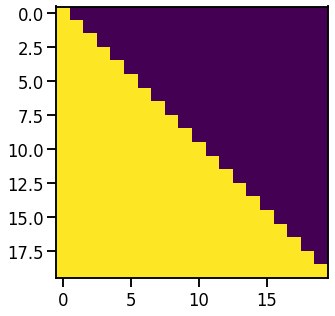

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

Embeddings

In [ ]:
class Embeddings(nn.Module):
  def __init__(self, d_model: int, n_vocab: int) -> NoReturn:
    super(Embeddings, self).__init__()
    self.lut = nn.Embedding(n_vocab, d_model)
    self.d_model = d_model

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.lut(x) * math.sqrt(self.d_model)

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self,
               d_model: int,
               dropout: float,
               max_len: int=5000) -> NoReturn:
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p=dropout)

    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len).unsqueeze(1) # max_len X 1
    div_term = torch.exp(torch.arange(0, d_model, 2) *
                         -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)
    self.register_buffer('pe', pe)

  def forward(self, x: torch.Tensor):
    x = x + self.pe[:, :x.size(1)].clone().detach().requires_grad_(False)
    return self.dropout(x)


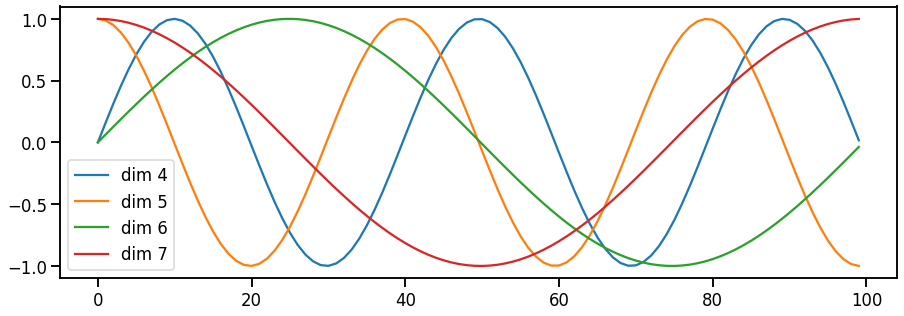

In [ ]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(torch.zeros(1, 100, 20))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend([f'dim {p}' for p in [4, 5, 6, 7]])
None

Tool

In [ ]:
def clones(module: nn.Module, N: int) -> nn.ModuleList:
  return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [ ]:
def clone_and_connect(module: nn.Module, N: int) -> nn.Sequential:
  return nn.Sequential(OrderedDict([(str(i), copy.deepcopy(module)) for i in range(N)]))

Full Model

In [ ]:
def make_model(src_vocab: int,
               tgt_vocab: int,
               N: int=6,
               d_model: int=512,
               d_ff: int=2048,
               h: int=8,
               dropout: float=0.1) -> nn.Module:
  c = copy.deepcopy
  #attn = MultiHeadedAttention(h, d_model)
  attn = MultiHeadAttentionLayer(d_model, h)
  #ff = PositionwiseFeedForward(d_model, d_ff)
  ff = PositionWiseFeedForwardLayer(d_model, d_ff)
  rc = ResidualConnectionLayer(d_model, dropout)
  pe = PositionalEncoding(d_model, dropout)
  model = EncoderDecoder(
      # Encoder(EncodeLayer(c(attn), c(ff), c(rc)), N),
      Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
      # Decoder(DecoderLayer(c(attn), c(ff), c(rc)), N),
      Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                           c(ff), dropout), N),
      nn.Sequential(Embeddings(d_model, src_vocab), c(pe)),
      nn.Sequential(Embeddings(d_model, tgt_vocab), c(pe)),
      Generator(d_model, tgt_vocab)
  )

  for p in model.parameters():
    if p.dim() > 1:
      nn.init.xavier_uniform(p)
  return model

Batches and Masking

In [ ]:
class Batch:

  def __init__(self,
               src: torch.Tensor,
               trg: Optional[torch.Tensor]=None,
               pad: int=0) -> NoReturn:
    self.src = src
    self.src_mask = (src != pad).unsqueeze(-2)
    if trg is not None:
      self.trg = trg[:, :-1]
      self.trg_y = trg[:, 1:]
      self.trg_mask = self.make_std_mask(self.trg, pad)
      self.ntokens = (self.trg_y != pad).sum()
      # print(f'ntokens: {self.ntokens}')


  @staticmethod
  def make_std_mask(tgt: torch.Tensor, pad: int) -> torch.Tensor:
    tgt_mask = (tgt != pad).unsqueeze(-2)
    tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(tgt_mask)
    return tgt_mask

Training Loop

In [ ]:
def run_epoch(data_iter: Iterable[Batch],
              model: nn.Module,
              loss_compute: Callable[[torch.Tensor, torch.Tensor], float]
              ) -> float:
  start = time.time()
  total_tokens = 0
  total_loss = 0
  tokens = 0
  for i, batch in enumerate(data_iter):
    out = model.forward(batch.src, batch.trg,
                        batch.src_mask, batch.trg_mask)
    loss = loss_compute(out, batch.trg_y, batch.ntokens)
    total_loss += loss
    total_tokens += batch.ntokens
    tokens += batch.ntokens
    if i % 50 == 1:
      elapsed = time.time() - start
      print(f'Epoch Step: {i} Loss: {loss / batch.ntokens}, Tokens per Sec: {tokens / elapsed}')
      start = time.time()
      tokens = 0
  return total_loss / total_tokens

Training Data and Batching

In [ ]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
  global max_src_in_batch, max_tgt_in_batch
  if count == 1:
    max_src_in_batch = 0
    max_tgt_in_batch = 0
  max_src_in_batch = max(max_src_in_batch, len(new.src))
  max_tgt_in_batch = max(max_tgt_in_batch, len(new.tgt) + 2)
  src_elements = count * max_src_in_batch
  tgt_elements = count * max_tgt_in_batch
  return max(src_elements, tgt_elements)

Optimizer

In [ ]:
class NoamOpt:
  def __init__(self,
               model_size: int,
               factor: int,
               warmup: int,
               optimizer: torch.optim.Optimizer) -> NoReturn:
    self.optimizer = optimizer
    self._step = 0
    self.warmup = warmup
    self.factor = factor
    self.model_size = model_size
    self._rate = 0

  def step(self) -> NoReturn:
    self._step += 1
    rate = self.rate()
    for p in self.optimizer.param_groups:
      p['lr'] = rate
    self._rate = rate
    self.optimizer.step()

  def rate(self, step: int=None) -> float:
    if step is None:
      step = self._step
    return self.factor * (self.model_size ** (-0.5) *
                          min(step ** (-0.5), step * self.warmup ** (-1.5)))
  
def get_std_opt(model: nn.Module) -> NoamOpt:
  return NoamOpt(model.src_embed[0].d_model, 2, 4000,
                 torch.optim.Adam(model.parameters(), lr=0,
                                  betas=(0.9, 0.98), eps=1e-9))

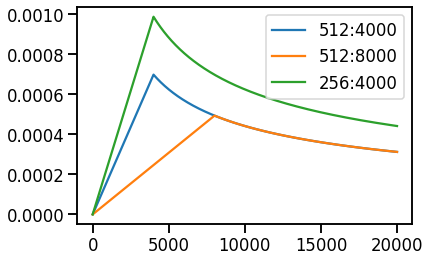

In [ ]:
opts = [NoamOpt(512, 1, 4000, None),
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000),
         [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(['512:4000', '512:8000', '256:4000'])
None

Label Smoothing

In [ ]:
class LabelSmoothing(nn.Module):
  def __init__(self,
               size: int,
               padding_idx: int,
               smoothing: float=0.0) -> NoReturn:
    super(LabelSmoothing, self).__init__()
    self.criterion = nn.KLDivLoss(reduction='sum')
    self.padding_idx = padding_idx
    self.confidence = 1.0 - smoothing
    self.smoothing = smoothing
    self.size = size
    self.true_dist = None

  def forward(self,
              x: torch.Tensor,
              target: torch.Tensor) -> float:
    assert x.size(1) == self.size
    true_dist = x.clone().detach().requires_grad_(False)
    true_dist.fill_(self.smoothing / (self.size - 2))
    true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
    true_dist[:, self.padding_idx] = 0
    mask = torch.nonzero(target == self.padding_idx)
    if mask.dim() > 0:
      true_dist.index_fill_(0, mask.squeeze(), 0.0)
    self.true_dist = true_dist
    # true_dist.required_grad_(False)
    return self.criterion(x, true_dist)




tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


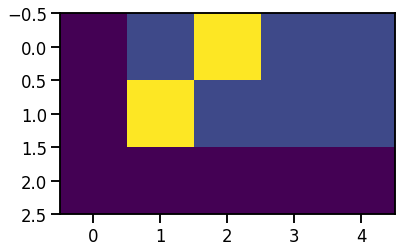

In [ ]:
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(predict.log(),
         torch.LongTensor([2, 1, 0]))

plt.imshow(crit.true_dist)
None

print(crit.true_dist)

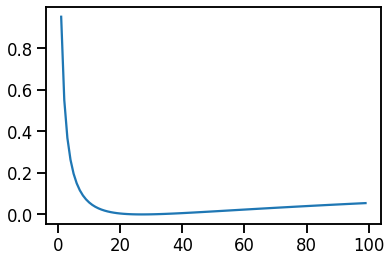

In [ ]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
  d = x + 3 * 1
  predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                               ])
  return crit(predict.log(),
              torch.LongTensor([1]))
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
None

# A First Example

Symthetic Data

In [ ]:
def data_gen(V: int,
             batch: int,
             nbatches: int) -> Iterable[Batch]:
  for i in range(nbatches):
    data = torch.randint(1, V, size=(batch, 10))
    data[:, 0] = 1
    src = data.clone().detach().requires_grad_(False)
    #print(f'batch: {i}')
    #print(src)
    tgt = data.clone().detach().requires_grad_(False)
    for row in range(batch):
      for col in range(2:10):
        tgt[row][col] +=(src[row][col - 1] > 5) - 2 * (src[row][col] > 5) + (tgr[row][col - 2] > 5) 
    yield Batch(src, tgt, 0)

Loss Computation

In [ ]:
class SimpleLossCompute:
  def __init__(self,
               generator: nn.Module,
               criterion: nn.Module,
               opt: NoamOpt=None) -> NoReturn:
    self.generator = generator
    self.criterion = criterion
    self.opt = opt

  def __call__(self, x, y, norm):
    x = self.generator(x)
    loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                          y.contiguous().view(-1)) / norm
    loss.backward()
    if self.opt is not None:
      self.opt.step()
      self.opt.optimizer.zero_grad()
    return loss * norm

replace,,,, :(

In [ ]:
from torch.autograd import Variable

In [ ]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        ##self.norm = LayerNorm(size)
        self.norm = nn.LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
        print('replaced SublayerConnection')

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [ ]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        #self.sublayer = clones(ResidualConnectionLayer(size, dropout), 2)
        self.size = size

        print('replaced EncoderLayer')

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [ ]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        #self.sublayer = clones(ResidualConnectionLayer(size, dropout), 3)

        print('replaced DecoderLayer')
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [ ]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = nn.LayerNorm(layer.size)
        
        print('replaced Encoder')

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [ ]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = nn.LayerNorm(layer.size)

        print('replaced Decoder')
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [ ]:
def make_model(src_vocab: int,
               tgt_vocab: int,
               N: int=6,
               d_model: int=512,
               d_ff: int=2048,
               h: int=8,
               dropout: float=0.1) -> nn.Module:
  c = copy.deepcopy
  #attn = MultiHeadedAttention(h, d_model)
  attn = MultiHeadAttentionLayer(d_model, h)
  #ff = PositionwiseFeedForward(d_model, d_ff)
  ff = PositionWiseFeedForwardLayer(d_model, d_ff)
  rc = ResidualConnectionLayer(d_model, dropout)
  pe = PositionalEncoding(d_model, dropout)
  model = EncoderDecoder(
      # Encoder(EncodeLayer(c(attn), c(ff), c(rc)), N),
      Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
      # Decoder(DecoderLayer(c(attn), c(ff), c(rc)), N),
      Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                           c(ff), dropout), N),
      nn.Sequential(Embeddings(d_model, src_vocab), c(pe)),
      nn.Sequential(Embeddings(d_model, tgt_vocab), c(pe)),
      Generator(d_model, tgt_vocab)
  )

  print('replaced make_model')

  for p in model.parameters():
    if p.dim() > 1:
      nn.init.xavier_uniform(p)
  return model

In [ ]:
from torch.nn import Transformer

In [ ]:
class EncoderDecoder(nn.Module):
  def __init__(self,
               N: int,
               d_model,
               d_ff,
               h,
               dropout: float,
               src_embed: nn.Module,
               tgt_embed: nn.Module,
               generator: nn.Module) -> NoReturn:
    super(EncoderDecoder, self).__init__()
    self.transformer = Transformer(d_model=d_model,
                                   nhead=h,
                                   num_encoder_layers=N,
                                   num_decoder_layers=N,
                                   dim_feedforward=d_ff,
                                   dropout=dropout,
                                   batch_first=True,
                                   norm_first=True)
    self.src_embed = src_embed
    self.tgt_embed = tgt_embed
    self.generator = generator

    print('used nn.Transformer')

  def forward(self,
              src: torch.Tensor,
              tgt: torch.Tensor,
              src_mask: torch.Tensor,
              tgt_mask: torch.Tensor) -> torch.Tensor:
    return self.transformer(self.src_embed(src), self.tgt_embed(tgt))

  def encode(self,
             src: torch.Tensor,
             src_mask: torch.Tensor) -> torch.Tensor:
    return self.encoder(self.src_embed(src), src_mask)

  def decode(self,
             memory: torch.Tensor,
             src_mask: torch.Tensor,
             tgt: torch.Tensor,
             tgt_mask: torch.Tensor):
    return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [ ]:
def make_model(src_vocab: int,
               tgt_vocab: int,
               N: int=6,
               d_model: int=512,
               d_ff: int=2048,
               h: int=8,
               dropout: float=0.1) -> nn.Module:
  c = copy.deepcopy
  #attn = MultiHeadedAttention(h, d_model)
  attn = MultiHeadAttentionLayer(d_model, h)
  #ff = PositionwiseFeedForward(d_model, d_ff)
  ff = PositionWiseFeedForwardLayer(d_model, d_ff)
  rc = ResidualConnectionLayer(d_model, dropout)
  pe = PositionalEncoding(d_model, dropout)
  model = EncoderDecoder(
      N,
      d_model,
      d_ff,
      h,
      dropout,
      nn.Sequential(Embeddings(d_model, src_vocab), c(pe)),
      nn.Sequential(Embeddings(d_model, tgt_vocab), c(pe)),
      Generator(d_model, tgt_vocab)
  )

  print('replaced make_model')

  for p in model.parameters():
    if p.dim() > 1:
      nn.init.xavier_uniform(p)
  return model

Greedy Decoding

In [ ]:
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
                    torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
  model.train()
  run_epoch(data_gen(V, 30, 20), model,
            SimpleLossCompute(model.generator, criterion, model_opt))
  model.eval()
  print(run_epoch(data_gen(V, 30, 5), model,
                  SimpleLossCompute(model.generator, criterion, None)))

replaced make_model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Epoch Step: 1 Loss: 3.0128283500671387, Tokens per Sec: 418.5338134765625
Epoch Step: 1 Loss: 1.8872572183609009, Tokens per Sec: 549.4417724609375
tensor(1.8919, grad_fn=<DivBackward0>)
Epoch Step: 1 Loss: 2.0644848346710205, Tokens per Sec: 438.087646484375
Epoch Step: 1 Loss: 1.7658586502075195, Tokens per Sec: 547.5096435546875
tensor(1.7905, grad_fn=<DivBackward0>)
Epoch Step: 1 Loss: 2.001941204071045, Tokens per Sec: 440.5306701660156
Epoch Step: 1 Loss: 1.8169066905975342, Tokens per Sec: 542.3504028320312
tensor(1.8064, grad_fn=<DivBackward0>)
Epoch Step: 1 Loss: 2.036073684692383, Tokens per Sec: 442.9109191894531
Epoch Step: 1 Loss: 1.9236565828323364, Tokens per Sec: 539.45751953125
tensor(1.9267, grad_fn=<DivBackward0>)
Epoch Step: 1 Loss: 1.9808405637741089, Tokens per Sec: 447.0649719238281
Epoch Step: 1 Loss: 1.7447808980941772, Tokens per Sec: 549.984375
tensor(1.6827, grad_fn=<DivBackward0>)
Epoch Step: 1 Loss: 1.7978178262710571, Tokens per Sec: 445.93365478515625
Ep

In [ ]:
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(512, 1, 400,
                    torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
  model.train()
  run_epoch(data_gen(V, 30, 20), model,
            SimpleLossCompute(model.generator, criterion, model_opt))
  model.eval()
  print(run_epoch(data_gen(V, 30, 5), model,
                  SimpleLossCompute(model.generator, criterion, None)))

used nn.Transformer
replaced make_model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Epoch Step: 1 Loss: 2.8879165649414062, Tokens per Sec: 424.5655212402344
Epoch Step: 1 Loss: 1.967314600944519, Tokens per Sec: 551.7342529296875
tensor(1.9819, grad_fn=<DivBackward0>)
Epoch Step: 1 Loss: 2.0326104164123535, Tokens per Sec: 447.3735046386719
Epoch Step: 1 Loss: 1.7891565561294556, Tokens per Sec: 552.6444091796875
tensor(1.8360, grad_fn=<DivBackward0>)
Epoch Step: 1 Loss: 1.9914422035217285, Tokens per Sec: 443.20550537109375
Epoch Step: 1 Loss: 1.747389554977417, Tokens per Sec: 548.4951782226562
tensor(1.7532, grad_fn=<DivBackward0>)
Epoch Step: 1 Loss: 2.0486390590667725, Tokens per Sec: 444.0847473144531
Epoch Step: 1 Loss: 1.6399595737457275, Tokens per Sec: 551.5330810546875
tensor(1.6729, grad_fn=<DivBackward0>)
Epoch Step: 1 Loss: 1.868904709815979, Tokens per Sec: 447.9782409667969
Epoch Step: 1 Loss: 1.1999799013137817, Tokens per Sec: 549.452392578125
tensor(1.2485, grad_fn=<DivBackward0>)
Epoch Step: 1 Loss: 1.138332724571228, Tokens per Sec: 447.649383544

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
  ys = torch.ones(1, 1).fill_(start_symbol).type_as(src)
  for i in range(max_len - 1):
    out = model.forward(src[:, :i + 1], ys, src_mask, subsequent_mask(ys.size(1)).type_as(src))
    prob = model.generator(out[:, -1])
    _, next_word = torch.max(prob, dim=1)
    next_word = next_word[0]
    ys = torch.cat([ys,
                    torch.ones(1, 1).type_as(src).fill_(next_word)], dim=1)
  return ys

In [ ]:
model.eval()
src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
src_mask = torch.ones(1, 1, 10)
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 8, 9]])


In [ ]:
rc = ResidualConnectionLayer(4, 0.1)

In [ ]:
copied_rc = copy.deepcopy(rc)

In [ ]:
for i, p in enumerate(copied_rc.parameters()):
  print(i)
  print(p)

0
Parameter containing:
tensor([1., 1., 1., 1.], requires_grad=True)
1
Parameter containing:
tensor([0., 0., 0., 0.], requires_grad=True)


Test

Sample

In [ ]:
def get_sample_batch():
  torch.manual_seed(0)
  data = torch.randint(1, 11, size=(3, 10))
  data[:, 0] = 1
  src = data.clone().detach().requires_grad_(False)
  tgt = data.clone().detach().requires_grad_(False)
  torch.manual_seed(0)
  batch = Batch(src, tgt)
  return batch

In [ ]:
def get_sample_model():
  encoder = get_sample_encoder()
  decoder = get_sample_decoder()
  src_embed = get_sample_embeddings()
  tgt_embed = get_sample_embeddings()
  generator = get_sample_generator()
  torch.manual_seed(0)
  model = EncoderDecoder(encoder,
                         decoder,
                         src_embed,
                         tgt_embed,
                         generator)
  for p in model.parameters():
    if p.dim() > 1:
      torch.manual_seed(0)
      nn.init.xavier_uniform_(p)
  return model

In [ ]:
def get_sample_embeddings():
  torch.manual_seed(0)
  embed = nn.Sequential(Embeddings(16, 11), PositionalEncoding(16, 0.1))
  return embed

In [ ]:
def get_sample_encoder():
  encoder_layer = get_sample_encoder_layer()
  torch.manual_seed(0)
  encoder = Encoder(encoder_layer, 2)
  return encoder

In [ ]:
def get_sample_encoder_layer():
  attn = get_sample_multi_headed_attention()
  ff = get_sample_position_wise_feed_forward()
  rc = get_sample_sublayer_connection()
  torch.manual_seed(0)
  encoder_layer = EncodeLayer(attn, ff, rc)
  return encoder_layer

In [ ]:
def get_sample_sublayer_connection():
  torch.manual_seed(0)
  rc = ResidualConnectionLayer(16, 0.1)
  return rc

In [ ]:
def get_sample_multi_headed_attention():
  torch.manual_seed(0)
  attn = MultiHeadAttentionLayer(16, 8)
  return attn

In [ ]:
def get_sample_position_wise_feed_forward():
  torch.manual_seed(0)
  ff = PositionWiseFeedForwardLayer(16, 64)
  return ff

In [ ]:
def get_sample_decoder():
  decoder_layer = get_sample_decoder_layer()
  torch.manual_seed(0)
  decoder = Decoder(decoder_layer, 2)
  return decoder

In [ ]:
def get_sample_decoder_layer():
  attn = get_sample_multi_headed_attention()
  ff = get_sample_position_wise_feed_forward()
  rc = get_sample_sublayer_connection()
  torch.manual_seed(0)
  decoder_layer = DecoderLayer(attn, ff, rc)
  return decoder_layer

In [ ]:
def get_sample_loss_compute(model):
  generator = model.generator
  criterion = get_sample_criterion()
  opt = get_sample_opt(model)
  torch.manual_seed(0)
  loss_compute = SimpleLossCompute(generator, criterion, opt)
  return loss_compute

In [ ]:
def get_sample_generator():
  torch.manual_seed(0)
  generator = Generator(16, 11)
  return generator

In [ ]:
def get_sample_criterion():
  torch.manual_seed(0)
  criterion = LabelSmoothing(11, 0, 0.0)
  return criterion

In [ ]:
def get_sample_opt(model):
  torch.manual_seed(0)
  opt = NoamOpt(16, 1, 400,
                torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
  return opt

Debug

In [ ]:
sample_batch = get_sample_batch()
print(sample_batch.src)
print(sample_batch.src_mask)
print(sample_batch.trg)
print(sample_batch.trg_y)
print(sample_batch.trg_mask)
print(sample_batch.ntokens)

tensor([[ 1, 10,  4,  1,  4, 10,  8,  4,  8,  4],
        [ 1,  7,  7, 10,  9,  7,  7,  9,  5,  4],
        [ 1, 10,  2,  5,  5,  2, 10, 10, 10,  1]])
tensor([[[True, True, True, True, True, True, True, True, True, True]],

        [[True, True, True, True, True, True, True, True, True, True]],

        [[True, True, True, True, True, True, True, True, True, True]]])
tensor([[ 1, 10,  4,  1,  4, 10,  8,  4,  8],
        [ 1,  7,  7, 10,  9,  7,  7,  9,  5],
        [ 1, 10,  2,  5,  5,  2, 10, 10, 10]])
tensor([[10,  4,  1,  4, 10,  8,  4,  8,  4],
        [ 7,  7, 10,  9,  7,  7,  9,  5,  4],
        [10,  2,  5,  5,  2, 10, 10, 10,  1]])
tensor([[[ True, False, False, False, False, False, False, False, False],
         [ True,  True, False, False, False, False, False, False, False],
         [ True,  True,  True, False, False, False, False, False, False],
         [ True,  True,  True,  True, False, False, False, False, False],
         [ True,  True,  True,  True,  True, False, Fals

In [ ]:
sample_embed = get_sample_embeddings()
sample_embed

Sequential(
  (0): Embeddings(
    (lut): Embedding(11, 16)
  )
  (1): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [ ]:
sample_embeded = sample_embed(sample_batch.src)
sample_embeded

tensor([[[ -6.0118,  -6.4264,   2.5184,   4.6378,   2.6615,  -5.8004,  -1.5172,
            9.3467,   3.3342,  -1.4911,  -0.7707,   1.9266,   6.1750,   0.0000,
            4.2058,  -2.6386],
         [  5.2334,  -3.8045,   1.6860,   0.5791,   4.5485,  -1.1109,   3.4178,
            3.8586,   1.4069,   2.0592,  -0.5300,   2.7131,  -1.3946,  -0.0000,
            1.0706,  -5.0943],
         [ -1.5197,   3.6264,   5.5938,   6.6290,  -6.3489,  12.4989,  -2.0325,
            2.6002,  -7.2192,  -1.3324,  -2.1256,  -1.1097,  -4.7399,   6.0664,
           -0.6245,   4.6922],
         [ -5.8550,  -8.6375,   3.4214,   4.1742,   2.9899,  -5.8500,  -1.4119,
            9.3417,   3.3675,  -1.4916,  -0.7601,   0.0000,   6.1783,   8.1615,
            4.2068,  -2.6386],
         [ -3.3709,   3.3625,   5.9965,   6.0674,  -6.1370,  12.4333,  -0.0000,
            2.5936,  -7.1970,  -1.3331,  -2.1185,  -1.1098,  -4.7377,   6.0664,
           -0.6238,   0.0000],
         [  3.2330,  -4.0896,   2.4515,  -0.4

In [ ]:
sample_embeded.shape

torch.Size([3, 10, 16])

In [ ]:
sample_model = get_sample_model()
sample_model

replaced LayerNorm
replaced Encoder


EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncodeLayer(
        (multi_head_attention_layer): MultiHeadAttentionLayer(
          (query_fc_layer): Linear(in_features=16, out_features=16, bias=True)
          (key_fc_layer): Linear(in_features=16, out_features=16, bias=True)
          (value_fc_layer): Linear(in_features=16, out_features=16, bias=True)
          (final_fc_layer): Linear(in_features=16, out_features=16, bias=True)
        )
        (attention_residual_connection_layer): ResidualConnectionLayer(
          (norm_layer): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (position_wise_feed_forward_layer): PositionWiseFeedForwardLayer(
          (first_fc_layer): Linear(in_features=16, out_features=64, bias=True)
          (second_fc_layer): Linear(in_features=64, out_features=16, bias=True)
        )
        (ff_residual_connection_layer): ResidualConnectionLayer(
       

In [ ]:
torch.manual_seed(0)
sample_model.train()
torch.manual_seed(0)
sample_out = sample_model.forward(sample_batch.src,
                                  sample_batch.trg,
                                  sample_batch.src_mask,
                                  sample_batch.trg_mask)
sample_out

RuntimeError: ignored

In [ ]:
for i, p in enumerate(sample_model.parameters()):
  print(i)
  print(p)
  print(p.grad)

0
Parameter containing:
tensor([[-0.0032,  0.2323, -0.3564, -0.3187, -0.1668,  0.1161, -0.0086,  0.3433,
         -0.0384,  0.1146, -0.1309, -0.0851, -0.4137, -0.2868, -0.1785,  0.0160],
        [ 0.1712,  0.2598, -0.2936, -0.1886,  0.1573,  0.3596, -0.0891,  0.3240,
         -0.0698,  0.0458,  0.3921, -0.4017, -0.2726, -0.1096, -0.1688,  0.3741],
        [-0.2807, -0.1993, -0.3025, -0.4055, -0.2528,  0.3722,  0.1932,  0.2099,
          0.0228, -0.2220,  0.0733, -0.4043, -0.3129, -0.2232,  0.2732,  0.2539],
        [-0.1920, -0.0156,  0.2769,  0.4305,  0.1719,  0.0585,  0.2903, -0.2550,
          0.0807, -0.3357, -0.3001, -0.2237,  0.1959,  0.1741, -0.2565,  0.1308],
        [ 0.2377, -0.0547,  0.0165,  0.1003,  0.2686,  0.4158, -0.3337, -0.1587,
          0.1702,  0.3588,  0.3768,  0.3821,  0.0862, -0.3765,  0.0398, -0.2709],
        [-0.4035,  0.3847,  0.3292, -0.4319,  0.0810, -0.0729, -0.0713, -0.1982,
          0.1665, -0.2565,  0.1587,  0.2190,  0.3100,  0.1619, -0.4286, -0.2809]

In [ ]:
sample_loss_compute = get_sample_loss_compute(sample_model)
sample_loss_compute

In [ ]:
torch.manual_seed(0)
sample_loss = sample_loss_compute(sample_out,
                                  sample_batch.trg_y,
                                  sample_batch.ntokens)
sample_loss

tensor(90.4734, grad_fn=<MulBackward0>)

In [ ]:
for i, p in enumerate(sample_model.parameters()):
  print(i)
  print(p)
  print(p.grad)

0
Parameter containing:
tensor([[-0.0033,  0.2323, -0.3564, -0.3187, -0.1668,  0.1161, -0.0085,  0.3433,
         -0.0385,  0.1145, -0.1309, -0.0851, -0.4136, -0.2867, -0.1785,  0.0161],
        [ 0.1712,  0.2598, -0.2936, -0.1886,  0.1572,  0.3595, -0.0891,  0.3240,
         -0.0698,  0.0458,  0.3921, -0.4017, -0.2726, -0.1096, -0.1688,  0.3741],
        [-0.2806, -0.1994, -0.3026, -0.4055, -0.2527,  0.3722,  0.1932,  0.2098,
          0.0228, -0.2220,  0.0732, -0.4043, -0.3129, -0.2233,  0.2732,  0.2539],
        [-0.1921, -0.0156,  0.2770,  0.4304,  0.1719,  0.0585,  0.2903, -0.2550,
          0.0807, -0.3357, -0.3001, -0.2237,  0.1959,  0.1741, -0.2565,  0.1308],
        [ 0.2377, -0.0546,  0.0165,  0.1003,  0.2687,  0.4158, -0.3337, -0.1587,
          0.1702,  0.3587,  0.3768,  0.3821,  0.0861, -0.3765,  0.0399, -0.2709],
        [-0.4036,  0.3847,  0.3293, -0.4320,  0.0810, -0.0730, -0.0713, -0.1982,
          0.1665, -0.2564,  0.1588,  0.2189,  0.3100,  0.1619, -0.4286, -0.2809]

In [ ]:
torch.manual_seed(0)
sample_out = sample_model.forward(sample_batch.src,
                                  sample_batch.trg,
                                  sample_batch.src_mask,
                                  sample_batch.trg_mask)
sample_out

tensor([[[-1.1666e+00, -1.0589e-01, -6.3402e-01, -4.1228e-01,  1.2475e-01,
           2.0924e+00,  5.8602e-01,  2.6919e-01,  2.5981e-01, -7.7509e-01,
           7.0735e-01, -2.1408e-01, -2.0324e+00,  9.6150e-01, -1.0368e+00,
           1.3763e+00],
         [-1.1290e+00, -2.7239e-02, -6.7051e-01,  5.2084e-03,  2.1343e-01,
           1.7280e+00,  3.2375e-01,  4.3434e-01, -4.1953e-01, -7.7127e-01,
           8.2037e-01, -1.4101e-01, -2.4349e+00,  1.4484e+00, -4.8307e-01,
           1.1040e+00],
         [-1.2415e+00, -5.8375e-01, -9.6859e-01, -6.3049e-02, -9.7113e-03,
           2.5423e+00,  2.6117e-01,  5.5635e-01, -3.1492e-01, -9.6613e-01,
           7.3187e-01, -9.9222e-02, -1.0575e+00,  1.0018e+00, -1.0358e+00,
           1.2469e+00],
         [-8.6478e-01, -1.8549e-01, -7.8679e-01,  5.1423e-01,  3.6385e-02,
           2.4340e+00,  4.3449e-01,  4.4898e-01, -7.8115e-02, -9.4778e-01,
           6.1151e-01, -2.6234e-01, -2.1659e+00,  4.3320e-01, -7.3518e-01,
           1.1139e+00],
    

In [ ]:
torch.manual_seed(0)
sample_loss = sample_loss_compute(sample_out,
                                  sample_batch.trg_y,
                                  sample_batch.ntokens)
sample_loss

tensor(88.6411, grad_fn=<MulBackward0>)

In [ ]:
for i, p in enumerate(sample_model.parameters()):
  print(i)
  print(p)
  print(p.grad)

0
Parameter containing:
tensor([[-3.7120e-03,  2.3276e-01, -3.5592e-01, -3.1914e-01, -1.6725e-01,
          1.1565e-01, -8.1092e-03,  3.4287e-01, -3.8897e-02,  1.1411e-01,
         -1.3133e-01, -8.5585e-02, -4.1321e-01, -2.8631e-01, -1.7897e-01,
          1.6504e-02],
        [ 1.7072e-01,  2.6024e-01, -2.9375e-01, -1.8902e-01,  1.5681e-01,
          3.5910e-01, -8.8644e-02,  3.2356e-01, -7.0265e-02,  4.5348e-02,
          3.9161e-01, -4.0216e-01, -2.7213e-01, -1.0915e-01, -1.6926e-01,
          3.7368e-01],
        [-2.8020e-01, -1.9980e-01, -3.0299e-01, -4.0507e-01, -2.5230e-01,
          3.7175e-01,  1.9369e-01,  2.0940e-01,  2.3243e-02, -2.2247e-01,
          7.2789e-02, -4.0477e-01, -3.1335e-01, -2.2370e-01,  2.7367e-01,
          2.5341e-01],
        [-1.9251e-01, -1.5154e-02,  2.7741e-01,  4.3000e-01,  1.7222e-01,
          5.8027e-02,  2.8986e-01, -2.5543e-01,  8.1160e-02, -3.3525e-01,
         -2.9965e-01, -2.2415e-01,  1.9547e-01,  1.7367e-01, -2.5697e-01,
          1.3035e-0